<a href="https://colab.research.google.com/github/stele-and-rivers-001/temp/blob/main/AI_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In the previous study, we looked at popular chat bot models, including OpenAI's GPT series. We explored some basics of *prompt engineering* to improve model performance, but now we will take it a step further. **AI agents** are entities, typically software programs, designed to act autonomously within an environment to achieve certain objectives. These agents utilize artificial intelligence techniques to perceive their environment, make decisions, and take actions to accomplish their goals. Think of it this way: When you ask GPT to write an essay, it works linearly from start to finish. This leaves no room for review, error correction or improvement. Agents can help by reviewing the essay for errors, allowing the model to access outside tools such as web pages or documents, and create an environment where the model can learn and improve as it goes. While anyone can ask ChatGPT questions, programmers can utilize agents to optimize performance beyond what was previously imaginable.

Here we will deep dive into GPT's popular agent system *Assistants*. Using agents can be quite costly as we will see the inputs, tools and resources all count as tokens towards usage. The entire thread of conversation is input for every new user message, which can amplify costs further. In order to save costs, we will only explore assistants with the GPT-3.5 model. For reference, this model scored a 90.5% accuracy in the previous study by simply prompting the model to categorize each job title into its respective industry. Let's see how much of an improvement assistants offer in this scenario.

See more in the OpenAI Assistants documentation:
https://platform.openai.com/docs/assistants/overview

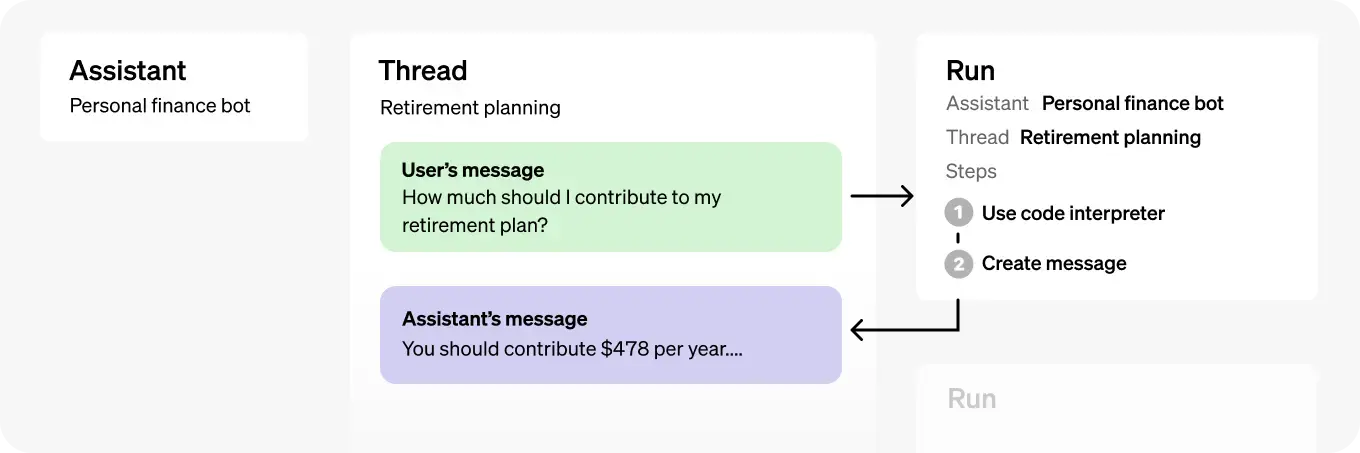

- *Thread:* A conversation session between an Assistant and a user. Threads store Messages and automatically handle truncation to fit content into a model’s context.
- *Message:* A message created by an Assistant or a user. Messages can include text, images, and other files. Messages stored as a list on the Thread.
- *Run:* An invocation of an Assistant on a Thread. The Assistant uses its configuration and the Thread’s Messages to perform tasks by calling models and tools. As part of a Run, the Assistant appends Messages to the Thread.
- *Run Steps:* A detailed list of steps the Assistant took as part of a Run. An Assistant can call tools or create Messages during its run. Examining Run Steps allows you to introspect how the Assistant is getting to its final results.


## Install libraries and import data

In [ ]:
!pip install -Uqq openai
!pip install -Uqq pymupdf
!pip install -Uqq matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 22.0 MB/s eta 0:00:00


In [ ]:
import base64
import os
from enum import Enum
from io import BytesIO
from typing import Iterable
from typing import List
from typing import Literal, Optional
import fitz
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from PIL import Image
import openai
from openai import OpenAI
from pydantic import BaseModel, Field
from google.colab import drive, files
import shutil
from pathlib import Path
import json
import time

In [ ]:
## mount google drive and import files to directory
drive.mount('/content/drive')

Import test data. This method does not require a training dataset as we are directly asking the chat model to categorize the data.

You can access the test data here:

https://drive.google.com/drive/folders/1tvp3-vZrcSRIuiMclQWnN-9f8nTGrexb?usp=drive_link

You'll need an API key to access the OpenAI models. The below code can be used for uploading and reading a file with your API key(s), but you can also use the Google Colab secrets panel.

In [ ]:
uploaded = files.upload()

Saving secrets.txt to secrets.txt


In [ ]:
with open('secrets.txt', 'r') as f:
    lines = f.readlines()

## set the openai key
openai_api_key = None
for line in lines:
    if line.startswith('OPENAI_API_KEY='):
        openai_api_key = line.strip().split('=')[1]
        break

In [ ]:
#### add your path to test_data.csv below ####
test_df = pd.read_csv('test_data.csv', sep='|')
test_df.columns

Index(['label', 'text'], dtype='object')

In [ ]:
test_df.columns = ['label','text']
test_df.tail()

,label,text
195,healthcare,Clinical Nurse Educator
196,retail_hospitality,Entertainment Coordinator
197,legal,Estate Planning Lawyer
198,technology,Technical Program Manager
199,healthcare,Oncology Nurse


In [ ]:
test_df.describe()

,label,text
count,200,200
unique,8,200
top,education,Education Technology Specialist
freq,36,1


In [ ]:
#hide
## show unique labels to ensure no typos or missing categories
unique_labels = test_df['label'].unique()
label_counts = test_df['label'].value_counts()

unique_labels_list = unique_labels.tolist()
print("Label Counts List:", unique_labels_list)

Label Counts List: ['education', 'technology', 'retail_hospitality', 'marketing_advertising', 'drama_arts', 'legal', 'healthcare', 'finance']


In [ ]:
## set the predictions df so that we can calculate accuracy
gpt_preds_df = test_df.copy()
#gpt_preds_df = gpt_preds_df.iloc[:5]
gpt_preds_df.head()

,label,text
0,education,Education Technology Specialist
1,technology,Incident Response Analyst
2,retail_hospitality,Spa Operations Manager
3,marketing_advertising,Data Analyst
4,drama_arts,Hair Assistant


# GPT Assistant

## Create assistant

Creating an assistant requires only the model to be specified but we will include additional parameters. We will also include a function to show the parameters of the assistant in json format after creation. *Instructions* is similar to *system prompt*, we will keep this unchanged. We will also name the assistant.

In [ ]:
openai.api_key = openai_api_key
client = OpenAI(api_key=openai_api_key)
## select a model from OpenAI's offerings
model = 'gpt-3.5-turbo'
#model = 'gpt-4-0613'

In [ ]:
## function to show parameters of assistant
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

In [ ]:
## set system prompt for environment
system_prompt = "You are a helpful assistant that categorizes job titles by industry."

Create the assistant. This only needs to be run once. Save the assistant_id variable to use and edit the assistant in the future.

In [ ]:
assistant = client.beta.assistants.create(
    name="Job Categorization Assistant",
    instructions=system_prompt,
    model=model,
)
## we will hide the actual output and provide a sample below to protect any potentially sensitive information
#show_json(assistant)

{'id': 'ASSISTANT ID INFORMATION',

 'created_at': 1717259597,

 'description': None,

 'instructions': 'You are a helpful assistant that
 categorizes job titles by industry.',

 'metadata': {},

 'model': 'gpt-3.5-turbo',

 'name': 'Job Industry Categorization Assistant',

 'object': 'assistant',

 'tools': [],

 'response_format': 'auto',

 'temperature': 1.0,

 'tool_resources': {'code_interpreter': None, 'file_search': None},

 'top_p': 1.0}

We can see from the json output that assistants support *functions* or *tools* , temperature, format, top_p, etc. OpenAI has hosted tools such as *code_interpreter* and *file_search* that can allow the assistant to write and run code or augment knowledge from outside files. In this study we will use file_search to provide additional data to the assistant, as well as a third-party function to ensure proper output structure. *tool_resources* is where access to files is provided.

## Add function

First let's create a function using the pydantic library to ensure output structure so that we can update our predictions dataframe properly.

**Pydantic** is a data validation library for python. It allows you to define data schemas using Python data classes, which are then used to validate and parse input data. We are going to replace the function calling for a "key" and "value" json format from the previous study with a pydantic class. This is a more effective way to ensure structured output. See the documentation for more:
https://docs.pydantic.dev/latest/

In [ ]:
## use pydantic to set structured output
class Jobs(BaseModel):
    """Represents the input text job title to be categorized and value being the existing industry value from the list. Include information such as best match for industry classification along with the probability and the second best match for industry classification along with the probability."""
    job_title: str = Field(..., description="The input text job title")
    industry_best: str = Field(..., description="The name of the best matching industry from the list provided. Must be in snake_case format.")
    best_prob: float = Field(..., description="The probability of the best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.")
    industry_second: str = Field(..., description="The name of the second best matching industry from the list provided. Must be in snake_case format.")
    second_prob: str = Field(..., description="The probability of the second best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.")

In [ ]:
## create schema for function call
## this will create the same function structure as study III, with the schema replaced by our pydantic object
def gen_gpt_function(function_name,function_description,function_json_schema):
    return {
        "type":"function",
        "function":{
            "name":function_name,
            "description":function_description,
            "parameters":function_json_schema
        }
    }

In [ ]:
schema_function = gen_gpt_function(function_name="categorize_job_title",function_description="function for categorizing a job title into an industry of best fit",function_json_schema=Jobs.schema())
print(Jobs.schema())
print(schema_function)

{'description': 'Represents the input text job title to be categorized and value being the existing industry value from the list. Include information such as best match for industry classification along with the probability and the second best match for industry classification along with the probability.', 'properties': {'job_title': {'description': 'The input text job title', 'title': 'Job Title', 'type': 'string'}, 'industry_best': {'description': 'The name of the best matching industry from the list provided. Must be in snake_case format.', 'title': 'Industry Best', 'type': 'string'}, 'best_prob': {'description': 'The probability of the best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.', 'title': 'Best Prob', 'type': 'number'}, 'industry_second': {'description': 'The name of the second best matching industry from the list provided. Must be in snake_case format.', 'title': 'Industry Second', 'type': 'string'}, 'second_prob': {'descr

Update the assistant to inlcude the schema function in its tools. We will also include enabling *file_search* to avoid having to update again later.

In [ ]:
## REDACT THIS BEFORE POSTING
## set the assistant id variable with your unique ID to edit the already created assistant
assistant_id = 'ASSISTANT ID INFORMATION'

assistant = client.beta.assistants.update(
    assistant_id=assistant_id,
    tools=[
        schema_function,
        {"type": "file_search"}
        ],
)

#show_json(assistant)

We can now see the pydantic function has been added to our assistant and file_search has been enabled.

{'id': 'ASSISTANT ID INFORMATION',

 'created_at': 1717259654,

 'description': None,

 'instructions': 'You are a helpful assistant that categorizes job titles by industry.',

 'metadata': {},

 'model': 'gpt-3.5-turbo',

 'name': 'Job Categorization Assistant',

 'object': 'assistant',

 'tools': [{'function': {'name': 'categorize_job_title',
    'description': 'function for categorizing a job title into an industry of best fit',
    'parameters': {'description': 'Represents the input text job title to be categorized and value being the existing industry value from the list. Include information such as best match for industry classification along with the probability and the second best match for industry classification along with the probability.',
     'properties': {'job_title': {'description': 'The input text job title',
       'title': 'Job Title',
       'type': 'string'},
      'industry_best': {'description': 'The name of the best matching industry from the list provided. Must be in snake_case format.',
       'title': 'Industry Best',
       'type': 'string'},
      'best_prob': {'description': 'The probability of the best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.',
       'title': 'Best Prob',
       'type': 'number'},
      'industry_second': {'description': 'The name of the second best matching industry from the list provided. Must be in snake_case format.',
       'title': 'Industry Second',
       'type': 'string'},
      'second_prob': {'description': 'The probability of the second best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.',
       'title': 'Second Prob',
       'type': 'string'}},
     'required': ['job_title',
      'industry_best',
      'best_prob',
      'industry_second',
      'second_prob'],
     'title': 'Jobs',
     'type': 'object'}},
   'type': 'function'},
  
  {'type': 'file_search'}],

 'response_format': 'auto',

 'temperature': 1.0,

 'tool_resources': {'code_interpreter': None,
  'file_search': {'vector_store_ids': []}},

 'top_p': 1.0}

## Add file search

Once enabled, the model decides when to retrieve content based on user messages.

The file_search tool uses the Vector Store object. We will upload our files and create a Vector Store to contain them. Once the Vector Store is created, we will then poll its status to ensure all files are out of the *in_progress* state.

In [ ]:
## Create a vector store called "Job Industry Data"
vector_store = client.beta.vector_stores.create(name="Job Industry Data")

## Ready the files for upload to OpenAI
file_paths = ["job_class_info.pdf", "examples.pdf"]
file_streams = [open(path, "rb") for path in file_paths]

## Use the upload and poll SDK helper to upload the files, add them to the vector store,
## and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)

## You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)

completed
FileCounts(cancelled=0, completed=2, failed=0, in_progress=0, total=2)


We then have to update the assistant's *tool_resources* which is where the model accesses our files. We saw above the 2 items were completed and now in the json output we can see the vector store id information.

In [ ]:
assistant = client.beta.assistants.update(
  assistant_id=assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)
#show_json(assistant)

{'id': 'ASSISTANT ID INFORMATION',

 'created_at': 1717259654,

 'description': None,

 'instructions': 'You are a helpful assistant that categorizes job titles by industry.',

 'metadata': {},

 'model': 'gpt-3.5-turbo',

 'name': 'Job Categorization Assistant',

 'object': 'assistant',

 'tools': [{'function': {'name': 'categorize_job_title',
    'description': 'function for categorizing a job title into an industry of best fit',
    'parameters': {'description': 'Represents the input text job title to be categorized and value being the existing industry value from the list. Include information such as best match for industry classification along with the probability and the second best match for industry classification along with the probability.',
     'properties': {'job_title': {'description': 'The input text job title',
       'title': 'Job Title',
       'type': 'string'},
      'industry_best': {'description': 'The name of the best matching industry from the list provided. Must be in snake_case format.',
       'title': 'Industry Best',
       'type': 'string'},
      'best_prob': {'description': 'The probability of the best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.',
       'title': 'Best Prob',
       'type': 'number'},
      'industry_second': {'description': 'The name of the second best matching industry from the list provided. Must be in snake_case format.',
       'title': 'Industry Second',
       'type': 'string'},
      'second_prob': {'description': 'The probability of the second best matching industry from the list provided. Must be a decimal between 0 and 1, e.g., 0.90 for 90%.',
       'title': 'Second Prob',
       'type': 'string'}},
     'required': ['job_title',
      'industry_best',
      'best_prob',
      'industry_second',
      'second_prob'],
     'title': 'Jobs',
     'type': 'object'}},
   'type': 'function'},
  
  {'type': 'file_search'}],

 'response_format': 'auto',

 'temperature': 1.0,

 'tool_resources': {'code_interpreter': None,

  'file_search': {'vector_store_ids': ['vs_JyqoDyhv5fCeocJaQlxcFpHl']}},

 'top_p': 1.0}

## Create thread

Create a new thread: This will hold the state of our conversation, so we don't have to re-send the entire message history for each request. Remember to save your thread_id information for later use.

In [ ]:
thread = client.beta.threads.create()
#show_json(thread)

Messages can contain text, images, or file attachments. Message attachments are helper methods that add files to a thread's *tool_resources*. You can also choose to add files to the thread *tool_resources* directly. Let's add a message to our thread.

We are going to use the same format of a *user_prompt* from the previous study the create our message for the assistant. The dynamic variable of *input_text* will be each job title as we loop through the dataframe and the *topics_list* is our list of industries to categorize each job title into.

In [ ]:
## function to create user prompt given the input text and the existing list of topics
def create_user_prompt(topics_list, input_text):

    user_prompt = f"""Categorize the job title from a list of industries. You must select a best fitting and second best fitting industry from the list and provide the probability values for each choice. You must pick a best fit and second best fit, even if the choice is unclear. Match the format of the choices from the list (ex. all undercase letters).

    Job Title:
    {input_text}
    List of Industries:
    {topics_list}
    """

    return user_prompt

We have options for how to send our messages and subsequent runs to the assistant. We could create a list of messages and submit them all at once in a single run. We could also create a singular messages and create a new run for each message. We will use the latter option, as it maintains the format of the previous study. We will submit a message one at a time to GPT asking it to classify a job title into the industry choices provided. This requires waiting until each run is completed before submitting another message, but is a bit less overwhelming than submitting an entire list of 200 items all at once for the model to deal with.

In [ ]:
## define function to create and send a message to the thread
def submit_message(assistant_id, thread_id, user_prompt):
    ## create the message
    client.beta.threads.messages.create(
        thread_id=thread.id, role="user", content=user_prompt
    )
    ## create the run
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    return run

## define a function to return the output messages from the model
def get_response(thread):
    return client.beta.threads.messages.list(thread_id=thread.id, order="asc")

## Run the job

**Runs are a key difference between the Assistants API and Chat Completions API. While in Chat Completions the model will only ever respond with a single message, in the Assistants API a Run may result in an Assistant using one or multiple tools, and potentially adding multiple messages to the Thread.**

A run can also have different status, it is important to be able to handle this properly. We will see this in our code later on when we loop through the list of job titles.

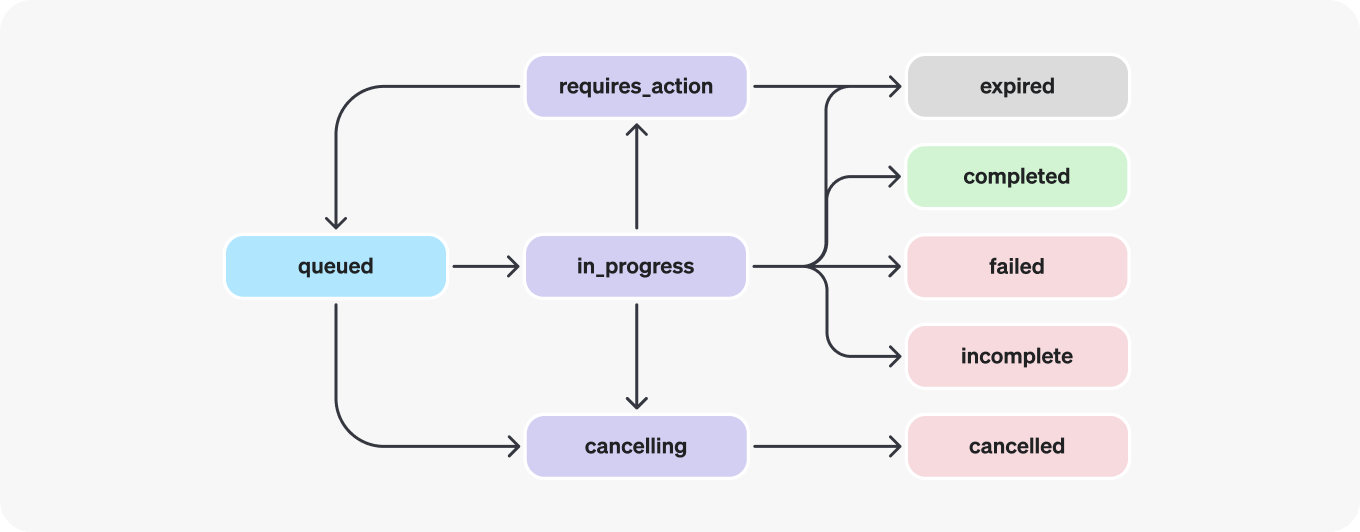

*requires_action:* When using the Function calling tool, the Run will move to a required_action state once the model determines the names and arguments of the functions to be called. You must then run those functions and submit the outputs before the run proceeds. If the outputs are not provided before the expires_at timestamp passes (roughly 10 mins past creation), the run will move to an expired status.

Here we create a function that returns values from the GPT output. We are requesting GPT provide a best and second best matching industry, as well as probabilities for each match. An added feature will be to inquire for user intervention if the probability difference between the best match and second best match is less than 15%. This will help identify difficult items for the model and allow users to have some level of oversight, as users may want in a real-world application.

In [ ]:
def job_class(arguments, unique_labels_list):
    ## Extract individual arguments from the dictionary
    job_title = arguments['job_title']
    industry_best = arguments['industry_best']
    best_prob = float(arguments['best_prob'])
    industry_second = arguments['industry_second']
    second_prob = float(arguments['second_prob'])

    ## Conditional check for user intervention
    if best_prob - second_prob < 0.15:
        input_text = f"{job_title} in {industry_best} and {industry_second}"
        while True:
            user_feedback = input(f"I am unsure which industry to categorize {input_text}. I chose {industry_best} with a probability of {best_prob}. Please provide the correct label, or hit enter to accept: ").strip()

            if not user_feedback:  ## User pressed enter without providing a value, keep label as is
                print("User accepted the chosen label.")
                break

            if user_feedback in unique_labels_list:  ## Check if the entered value is in the unique_labels_list
                ## update the value
                industry_best = user_feedback
                break
            else:
                print("Invalid label. Please provide a label from the list:", unique_labels_list)


    ## Return the dictionary with the possibly updated industry_best
    return {
        'job_title': job_title,
        'industry_best': industry_best,
        'best_prob': best_prob,
        'industry_second': industry_second,
        'second_prob': second_prob
    }

In [ ]:
## printing helper
def pretty_print(messages):
    print("# Messages")
    for m in messages:
        print(f"{m.role}: {m.content[0].text.value}")
    print()

Here is where we will loop through each item in our dataframe of job titles and ask the GPT assistant to categorize them by industry. This loop contains conditional statements to ensure each job has completed before submitting another request. When a tool requires action, we will call the appropriate function that takes the output and updates the predictions dataframe. At the end we will show a sample output from GPT to see how it looks. Just as in the previous study, the output for all 200 items is quite lengthy, so only a sample will be shown.

In [ ]:
## function to retrieve updated run data from a specific thread
def retrieve_run(thread_id, run_id):

    run = client.beta.threads.runs.retrieve(
        thread_id=thread_id,
        run_id=run_id,
    )
    return run

In [ ]:
## loop through the text column in the test_df
for i, text in enumerate(gpt_preds_df['text']):
    print("Job Title: ", text)
    ## use a while loop to run the loop continuously until a valid response is obtained from GPT
    while True:
        try:
            ## run the user_prompt function, inputting the list of industries and the job title to be categorized
            user_prompt = create_user_prompt(unique_labels_list, text)
            ## submit message with updated user prompt and create a run, returns a run
            run = submit_message(assistant.id, thread.id, user_prompt)
            ## check the status of the run and make decisions based on status
            while True:
                if run.status == "queued" or run.status == "in_progress":
                    ## retrieve updates run status with function that delays 2 seconds
                    run = retrieve_run(thread.id, run.id)
                    time.sleep(2)  ## Pause for 2 seconds to avoid nonstop inquiries to GPT
                ## if run status requires action (function call)
                elif run.status == "requires_action":
                    ## extract information about the tool call and arguments
                    tool_call = run.required_action.submit_tool_outputs.tool_calls[0]
                    name = tool_call.function.name
                    arguments = json.loads(tool_call.function.arguments)
                    #print("Function Name: ", name)
                    #print("Function Arguments: ", arguments)
                    ## run the function that accepts the output from our pydantic schema and set variables
                    extracted_arguments = job_class(arguments, unique_labels_list)
                    ## update the predictions df
                    gpt_preds_df.at[i, 'predicted_label'] = extracted_arguments['industry_best']
                    gpt_preds_df.at[i, 'best_prob'] = extracted_arguments['best_prob']
                    gpt_preds_df.at[i, 'industry_second'] = extracted_arguments['industry_second']
                    gpt_preds_df.at[i, 'second_prob'] = extracted_arguments['second_prob']
                    #print("Responses: ", extracted_arguments)
                    ## submit responses back to the assistant
                    run = client.beta.threads.runs.submit_tool_outputs(
                        thread_id=thread.id,
                        run_id=run.id,
                        tool_outputs=[
                            {
                                "tool_call_id": tool_call.id,
                                "output": json.dumps(extracted_arguments),
                            }
                        ],
                    )
                    #print("Show JSON: ")
                    #show_json(run)
                    ## wait for run to complete
                    while True:
                        if run.status == "queued" or run.status == "in_progress":
                            ## retrieve updates run status with function that delays 2 seconds
                            run = retrieve_run(thread.id, run.id)
                            time.sleep(2)  ## Pause for 2 seconds to avoid nonstop inquiries to GPT
                        else:
                            break
                    ## run the function to list the response messages from the model
                    print("Get Reponse Thread: ")
                    pretty_print(get_response(thread))
                else:
                    #print("Run Status: ")
                    #print(run.status)
                    break
            break ## exit the status while loop
        ## GPT restricts users by setting a rate limit. If a RateLimitError occurs, pause for a minute and continue
        except Exception as e:
            print(f"An error occurred: {e}")
            if "Rate limit exceeded" in str(e):
                print(f"Rate limit exceeded. Waiting for 60 seconds to retry")
                time.sleep(60)
            else:
                break  ## Exit the loop for other exceptions

Sample Output:

"user: Categorize the job title from a list of industries. You must select a best fitting and second best fitting industry from the list and provide the probability values for each choice. You must pick a best fit and second best fit, even if the choice is unclear. Match the format of the choices from the list (ex. all undercase letters).

  Job Title:
  Loan Officer
  
  List of Industries:
  ['education', 'technology', 'retail_hospitality', 'marketing_advertising', 'drama_arts', 'legal', 'healthcare', 'finance']

assistant: The job title "Loan Officer" is categorized as follows:

- Best Fit Industry: finance (with a probability of 0.9)
- Second Best Fit Industry: retail_hospitality (with a probability of 0.6)"

We found this process to take about an hour, much longer than simply submitting each item to the API without any assistants. We also found that if the human intervention function is to be included, it is important to try out different conditions for intervention to see what works best for your task. Occasionally, the model would ask for assistance with a best_prob of over 95%, which might be better off left to its own devices. We also noticed it gets into routines where it asks for assistance on many prompts in bunches and then operates independently in bunches. That function was still found to be useful for correcting decisions and also by providing insight into the model performance. Now let's see if that extra time and effort was worth it in terms of performance.

Here we will load in our predictions dataframe that was created when the previous cell was run. This step is not necessary if the previous loop was run in the current session. It takes a while to loop through the entire test data and can also be costly, so to save resources we will load a previosuly created predictions dataframe to test the accuracy in this notebook.

In [ ]:
## load in the previously created predictions dataframe
gpt_preds_df = pd.read_csv('predictions_gpt3.5_agents_final.csv')

In [ ]:
gpt_preds_df.head()

,label,text,predicted_label,best_prob,industry_second,second_prob
0,education,Education Technology Specialist,technology,0.8,education,0.6
1,technology,Incident Response Analyst,technology,0.7,legal,0.5
2,retail_hospitality,Spa Operations Manager,retail_hospitality,0.9,healthcare,0.6
3,marketing_advertising,Data Analyst,technology,0.9,finance,0.7
4,drama_arts,Hair Assistant,retail_hospitality,0.9,drama_arts,0.6


## Test accuracy

In [ ]:
## function for testing accuracy of predictions
def test_set_accuracy(test_df):
  accuracy = (test_df['predicted_label'] == test_df['label']).mean()
  print(f"Accuracy: {accuracy}")

In [ ]:
test_set_accuracy(gpt_preds_df)

Accuracy: 0.955


During testing, we found a few issues with the assistant performance. The following are helpful methods to troubleshoot in order to optimize prompt engineering and get the most out of the model.

First we noticed that GPT was providing different formats for the probability values. This ranged from the percentage value (90%) to the decimal value (0.9) to an integer (90). This was initially discovered by creating a histogram to show the values and discovering out of range values on the chart. After viewing the histogram, we added additional context to the pydantic funciton to ensure consistent output.

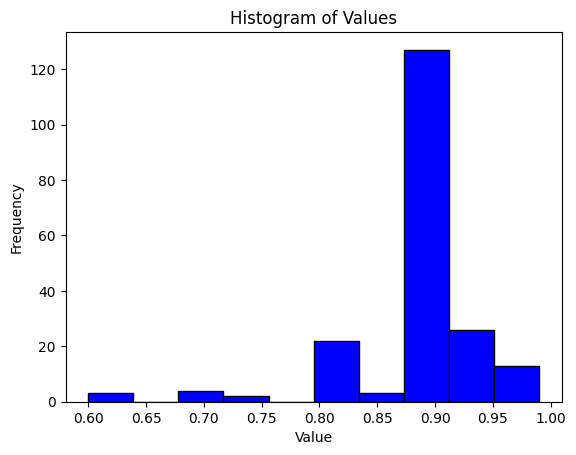

In [ ]:
import matplotlib.pyplot as plt

## Plot histogram for the 'Values' column
plt.hist(gpt_preds_df['best_prob'], bins=10, color='blue', edgecolor='black')

## Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

## Show the plot
plt.show()

In [ ]:
## save predictions as csv
gpt_preds_df.to_csv('predictions_gpt3.5_agents_final.csv', index=False)

Below is a way to identify the still incorrect labels. This is a good way to identify specific problem areas. Perhaps the model struggles with a certain category (ex. drama_arts) or after running multiple times the same few job titles are almost always mislabeled. These can be identified by creating a table of mismatched predictions for higher visibility to the user.

In [ ]:
mismatch_df = gpt_preds_df[gpt_preds_df['label'] != gpt_preds_df['predicted_label']]
mismatch_df

,label,text,predicted_label,best_prob,industry_second,second_prob
0,education,Education Technology Specialist,technology,0.80,education,0.60
3,marketing_advertising,Data Analyst,technology,0.90,finance,0.70
4,drama_arts,Hair Assistant,retail_hospitality,0.90,drama_arts,0.60
10,drama_arts,Publicity Assistant,marketing_advertising,0.80,drama_arts,0.60
48,drama_arts,Video Editor,technology,0.90,drama_arts,0.70
143,drama_arts,Box Office Assistant,retail_hospitality,0.60,drama_arts,0.25
146,legal,Forensic Psychologist,healthcare,0.95,legal,0.05
147,marketing_advertising,UX/UI Designer,technology,0.80,marketing_advertising,0.15
196,retail_hospitality,Entertainment Coordinator,drama_arts,0.95,retail_hospitality,0.04


We can see most of these predictions are fairly confident, showing there are still limitations at this time, but the technology is constantly improving to close the gap.

## Conclusion

On its own, GPT-3.5 with assistants was able to improve its accuracy score to 94% from 90.5%. This is a nice boost as we get closer to 100% accuracy. With the user intervention, we were able to further boost performance to 95.5%. This means GPT mislabeled with confidence (or at least past our confidence threshold for user intervention) only 4.5% of the items in the list. While this entire process took about an hour to complete, significantly longer than the previous study, the utlization of assistants may be important for certain use cases. For this simple task, maybe not so much, but perhaps in your real-world application accuracy is paramount and it is well worth applying the extra time and resources.

Assistants are still very new to the world of AI as of the time of this writing, and it is assumed they will continue to improve and incorporate more tools and capabilities. It is important to be able to utilize these resources in order to get the absolute most out of AI and stay ahead of the curve. While this study concludes our time applying AI tools and methods for text classification on a small dataset, we will continue publishing studies in the ever expanding world of AI and hope to continue providing insight to our readers.


As a reminder, this series is meant to be a survey of techniques for improving performance of NLP classification tasks with small datasets.

Stay tuned for more case studies like this one and if there is something you would like to chat about, feel free to reach out at:

shane@stelerivers.com